In [10]:
import os
import warnings
from cleverhans.attacks import FastGradientMethod
from io import BytesIO
import IPython.display
import numpy as np
import pandas as pd
from PIL import Image
from scipy.misc import imread
from scipy.misc import imsave
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
from cleverhans.model import Model

slim = tf.contrib.slim
tensorflow_master = ""
checkpoint_path   = "../input/inception-v3/inception_v3.ckpt"
input_dir         = "../input/nips-2017-adversarial-learning-development-set/images/"
max_epsilon       = 16.0
image_width       = 299
image_height      = 299
batch_size        = 16

eps = 2.0 * max_epsilon / 255.0
batch_shape = [batch_size, image_height, image_width, 3]
num_classes = 1001

def load_images(input_dir, batch_shape):
    images = np.zeros(batch_shape)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    images = np.zeros(batch_shape)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    for filepath in tf.gfile.Glob(os.path.join(input_dir, '*.png')):
      print(filepath)
     # --- change open method . This change has no impact for code ---
      with open(filepath,"rb") as f:
        image = np.array(Image.open(f).convert('RGB')).astype(np.float) / 255.0
      # Images for inception classifier are normalized to be in [-1, 1] interval.
      images[idx, :, :, :] = image * 2.0 - 1.0
      filenames.append(os.path.basename(filepath))
      idx += 1
      if idx == batch_size:
        yield filenames, images
        filenames = []
        images = np.zeros(batch_shape)
        idx = 0
    if idx > 0:
      yield filenames, images
    

def show_image(a, fmt='png'):
    a = np.uint8((a+1.0)/2.0*255.0)
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

class InceptionModel(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.built = False

    def __call__(self, x_input):
        """Constructs model and return probabilities for given input."""
        reuse = True if self.built else None
        with slim.arg_scope(inception.inception_v3_arg_scope()):
            _, end_points = inception.inception_v3(
                            x_input, num_classes=self.num_classes, is_training=False,
                            reuse=reuse)
        self.built = True
        output = end_points['Predictions']
        probs = output.op.inputs[0]
        return probs

..\input\nips-2017-adversarial-learning-development-set\images\000b7d55b6184b08.png
..\input\nips-2017-adversarial-learning-development-set\images\001b5e6f1b89fd3b.png
..\input\nips-2017-adversarial-learning-development-set\images\00312c7e7196baf4.png
..\input\nips-2017-adversarial-learning-development-set\images\00c3cd597f1ee96f.png
..\input\nips-2017-adversarial-learning-development-set\images\01244097ca8ffdfa.png
..\input\nips-2017-adversarial-learning-development-set\images\0134ba03294509a1.png
..\input\nips-2017-adversarial-learning-development-set\images\014f0024918a7b6f.png
..\input\nips-2017-adversarial-learning-development-set\images\01bdc0cfe670f708.png
..\input\nips-2017-adversarial-learning-development-set\images\01dd15caa1b2c7b4.png
..\input\nips-2017-adversarial-learning-development-set\images\01f824264783f58d.png
..\input\nips-2017-adversarial-learning-development-set\images\01fa4be27dd11b5d.png
..\input\nips-2017-adversarial-learning-development-set\images\0212aa8aa912e

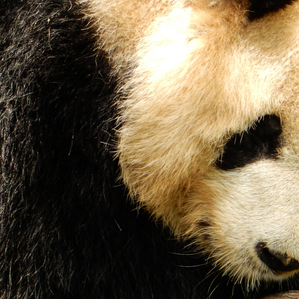

In [12]:
categories = pd.read_csv("../input/nips-2017-adversarial-learning-development-set/categories.csv")
image_classes = pd.read_csv("../input/nips-2017-adversarial-learning-development-set/images.csv")
image_iterator = load_images(input_dir, batch_shape)

# get first batch of images
filenames, images = next(image_iterator)

image_metadata = pd.DataFrame({"ImageId": [f[:-4] for f in filenames]}).merge(image_classes,
                                                                              on="ImageId")
true_classes = image_metadata["TrueLabel"].tolist()
target_classes = true_labels = image_metadata["TargetClass"].tolist()
true_classes_names = (pd.DataFrame({"CategoryId": true_classes})
                        .merge(categories, on="CategoryId")["CategoryName"].tolist())
target_classes_names = (pd.DataFrame({"CategoryId": target_classes})
                          .merge(categories, on="CategoryId")["CategoryName"].tolist())

print("Here's an example of one of the images in the development set")
show_image(images[0])

In [13]:
tf.logging.set_verbosity(tf.logging.INFO)


with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)
    model = Model(InceptionModel(num_classes))

    fgsm  = FastGradientMethod(model)
    x_adv = fgsm.generate(x_input, eps=eps, clip_min=-1., clip_max=1.)

    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        nontargeted_images = sess.run(x_adv, feed_dict={x_input: images})

print("The original image is on the left, and the nontargeted adversarial image is on the right. They look very similar, don't they? It's very clear both are gondolas")
show_image(np.concatenate([images[1], nontargeted_images[1]], axis=1))

TypeError: __init__() takes 1 positional argument but 2 were given

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../input/inception-v3/inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The original image is on the left, and the targeted adversarial image is on the right. Again, they look very similar, don't they? It's very clear both are butterflies


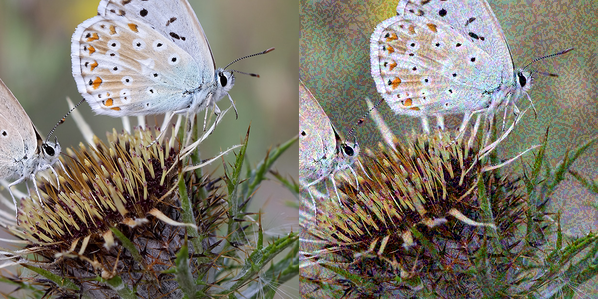

In [14]:
all_images_target_class = {image_metadata["ImageId"][i]+".png": image_metadata["TargetClass"][i]
                           for i in image_metadata.index}

with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, end_points = inception.inception_v3(
            x_input, num_classes=num_classes, is_training=False)

    target_class_input = tf.placeholder(tf.int32, shape=[batch_size])
    one_hot_target_class = tf.one_hot(target_class_input, num_classes)
    cross_entropy = tf.losses.softmax_cross_entropy(one_hot_target_class,
                                                    logits,
                                                    label_smoothing=0.1,
                                                    weights=1.0)
    cross_entropy += tf.losses.softmax_cross_entropy(one_hot_target_class,
                                                     end_points['AuxLogits'],
                                                     label_smoothing=0.1,
                                                     weights=0.4)
    x_adv = x_input - eps * tf.sign(tf.gradients(cross_entropy, x_input)[0])
    x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)

    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
        scaffold=tf.train.Scaffold(saver=saver),
        checkpoint_filename_with_path=checkpoint_path,
        master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        target_class_for_batch = ([all_images_target_class[n] for n in filenames]
                                  + [0] * (batch_size - len(filenames)))
        targeted_images = sess.run(x_adv,
                                   feed_dict={x_input: images,
                                              target_class_input: target_class_for_batch})
        
print("The original image is on the left, and the targeted adversarial image is on the right. Again, they look very similar, don't they? It's very clear both are butterflies")
show_image(np.concatenate([images[2], targeted_images[2]], axis=1))

In [15]:
with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(x_input, num_classes=num_classes, is_training=False)
    
    predicted_labels = tf.argmax(end_points['Predictions'], 1)

    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        predicted_classes = sess.run(predicted_labels, feed_dict={x_input: images})
        predicted_nontargeted_classes = sess.run(predicted_labels, feed_dict={x_input: nontargeted_images})
        predicted_targeted_classes = sess.run(predicted_labels, feed_dict={x_input: targeted_images})

predicted_classes_names = (pd.DataFrame({"CategoryId": predicted_classes})
                           .merge(categories, on="CategoryId")["CategoryName"].tolist())

predicted_nontargeted_classes_names = (pd.DataFrame({"CategoryId": predicted_nontargeted_classes})
                          .merge(categories, on="CategoryId")["CategoryName"].tolist())

predicted_targeted_classes_names = (pd.DataFrame({"CategoryId": predicted_targeted_classes})
                          .merge(categories, on="CategoryId")["CategoryName"].tolist())

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../input/inception-v3/inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


NameError: name 'nontargeted_images' is not defined

In [16]:
for i in range(len(images)):
    print("UNMODIFIED IMAGE (left)",
          "\n\tPredicted class:", predicted_classes_names[i],
          "\n\tTrue class:     ", true_classes_names[i])
    print("NONTARGETED ADVERSARIAL IMAGE (center)",
          "\n\tPredicted class:", predicted_nontargeted_classes_names[i])
    print("TARGETED ADVERSARIAL IMAGE (right)",
          "\n\tPredicted class:", predicted_targeted_classes_names[i],
          "\n\tTarget class:   ", target_classes_names[i])
    show_image(np.concatenate([images[i], nontargeted_images[i], targeted_images[i]], axis=1))


NameError: name 'predicted_classes_names' is not defined